In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class SmallPolicy(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class RewardModel(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
def generate_samples(policy, batch=32):
    # random input embeddings (32 sentences, each 10-dim)
    x = torch.randn(batch, 10)
    
    # policy decides "quality"
    scores = policy(x)
    
    # second candidate = x + slight noise
    x2 = x + 0.1 * torch.randn_like(x)

    scores2 = policy(x2)

    return x, x2, scores, scores2

In [5]:
def simulate_preferences(scores1, scores2):
    # Higher score = preferred
    return (scores1 > scores2).float()

In [6]:
def train_reward_model(reward_model, x1, x2, prefs, epochs=200):
    opt = optim.Adam(reward_model.parameters(), lr=1e-3)
    
    loss_history = []
    for _ in range(epochs):
        r1 = reward_model(x1)
        r2 = reward_model(x2)

        # preference loss = logistic loss
        logits = r1 - r2
        loss = F.binary_cross_entropy_with_logits(logits, prefs)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_history.append(loss.item())
    
    return loss_history

In [7]:
def update_policy(policy, reward_model, x, epochs=200):
    opt = optim.Adam(policy.parameters(), lr=1e-3)
    
    loss_history = []
    for _ in range(epochs):
        scores = policy(x)
        rewards = reward_model(x).detach()

        # Policy gradient style loss (maximize reward)
        loss = -torch.mean(scores * rewards)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_history.append(loss.item())
        
    return loss_history

In [8]:
policy = SmallPolicy()
reward_model = RewardModel()

x1, x2, scores1, scores2 = generate_samples(policy, batch=64)
prefs = simulate_preferences(scores1, scores2)

reward_loss = train_reward_model(reward_model, x1, x2, prefs)
policy_loss = update_policy(policy, reward_model, x1)

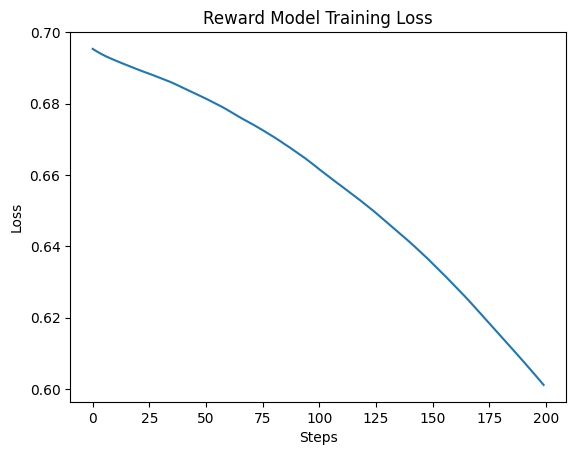

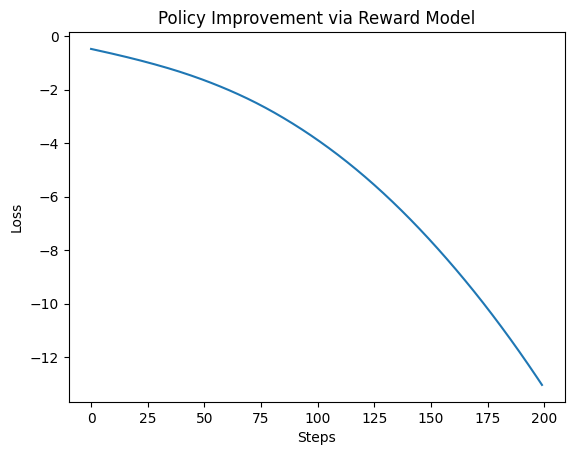

In [9]:
plt.plot(reward_loss)
plt.title("Reward Model Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

plt.plot(policy_loss)
plt.title("Policy Improvement via Reward Model")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()